# processing - new format

The datastream includes both data and features for every recorded samples.

In [2]:
import plotly.express as px

In [3]:
from nbimports import *

In [4]:
import processing
processing = reload(processing)

In [5]:
filename = "../data/user/data_04052022_140641.csv"

In [6]:
data = pd.read_csv(filename, index_col=0)
data.columns = ['source', 'data']

In [7]:
new_rows = []
default_value = np.ones(3) * np.nan

for i, row in data.iterrows():
    row = eval(row['data'].replace("false", "False"))

    key = row['sample_key']
    t0 = row['timestamp0']
    ts = row['timestamp']
    stroke_id = row['stroke_id']
    segment_id = row['segment_id']

    x, y, p = row.get('xyp', default_value)
    x_, y_, p_ = row.get('rel_xyp', default_value)
    x0, y0, p0 = row.get('rel_xyp_lp', default_value)
    x1, y1, p1 = row.get('xyp_sg', default_value)
    s = row['s']
    da = row['da']
    da = da[0] if isinstance(da, (list,)) else da
    
    new_row = [key, t0, ts, stroke_id, segment_id, x, y, p, x_, y_, p_, x0, y0, p0, x1, y1, p1, s, da]
    new_rows.append(new_row)

data_df = pd.DataFrame(data=new_rows, 
                    columns=['key', 't0', 'ts',
                             'stroke_id', 'segment_id',
                             'x', 'y', 'p', 'x_', 'y_', 'p_', 
                             'x0', 'y0', 'p0', 'x1', 'y1', 'p1',
                             's', 'da']
                   )

In [8]:
data['source']

0        /data
1        /data
2        /data
3        /data
4        /data
         ...  
15174    /data
15175    /data
15176    /data
15177    /data
15178    /data
Name: source, Length: 15179, dtype: object

In [9]:
import sklearn.preprocessing as skprep

In [10]:
mms = skprep.MinMaxScaler()

In [11]:
data_df['t0_'] = mms.fit_transform(data_df['t0'].values.reshape(-1, 1)).reshape(-1)

In [12]:
data_df['t0_']

0        0.000000
1        0.000057
2        0.000129
3        0.004856
4        0.004922
           ...   
15174    0.999776
15175    0.999862
15176    0.999862
15177    1.000000
15178    1.000000
Name: t0_, Length: 15179, dtype: float64

## figure all

In [13]:
data_df.head()

key      t0  ts  stroke_id  segment_id         x         y         p  \
0  509910_50  509910  50         10         114  0.324056  0.416593  0.014916   
1  509922_60  509922  60         10         114  0.331988  0.422836  0.012841   
2  509937_70  509937  70         10         114  0.340850  0.429163  0.010398   
3  510929_50  510929  50         11         114  0.171179  0.496804  0.028532   
4  510943_60  510943  60         11         114  0.178154  0.493724  0.029221   

         x_        y_        p_        x0        y0        p0        x1  \
0  0.007495  0.008146 -0.001902  0.000223  0.000232 -0.000107  0.000081   
1  0.015428  0.014389 -0.003977  0.000585  0.000608 -0.000247  0.000186   
2  0.024290  0.020715 -0.006420  0.001274  0.001324 -0.000479  0.000369   
3  0.003844 -0.001151  0.006770  0.000059 -0.000013  0.000277  0.000024   
4  0.010819 -0.004231  0.007459  0.000179 -0.000043  0.000672  0.000063   

         y1        p1         s   da       t0_  
0  0.000084 -0.000035  0.011668  0.0  0.000000  
1  0.000193 -0.000072  0.026773  0.0  0.000057  
2  0.000381 -0.000129  0.053039  0.0  0.000129  
3 -0.000006  0.000095  0.002459  0.0  0.004856  
4 -0.000016  0.000202  0.006481  0.0  0.004922

<AxesSubplot:xlabel='x', ylabel='y'>

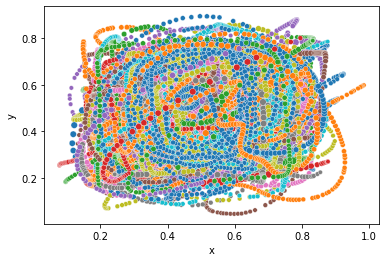

In [14]:
sns.scatterplot(data=data_df, x='x', y='y', size='p', hue='stroke_id', palette='tab10', legend=False)

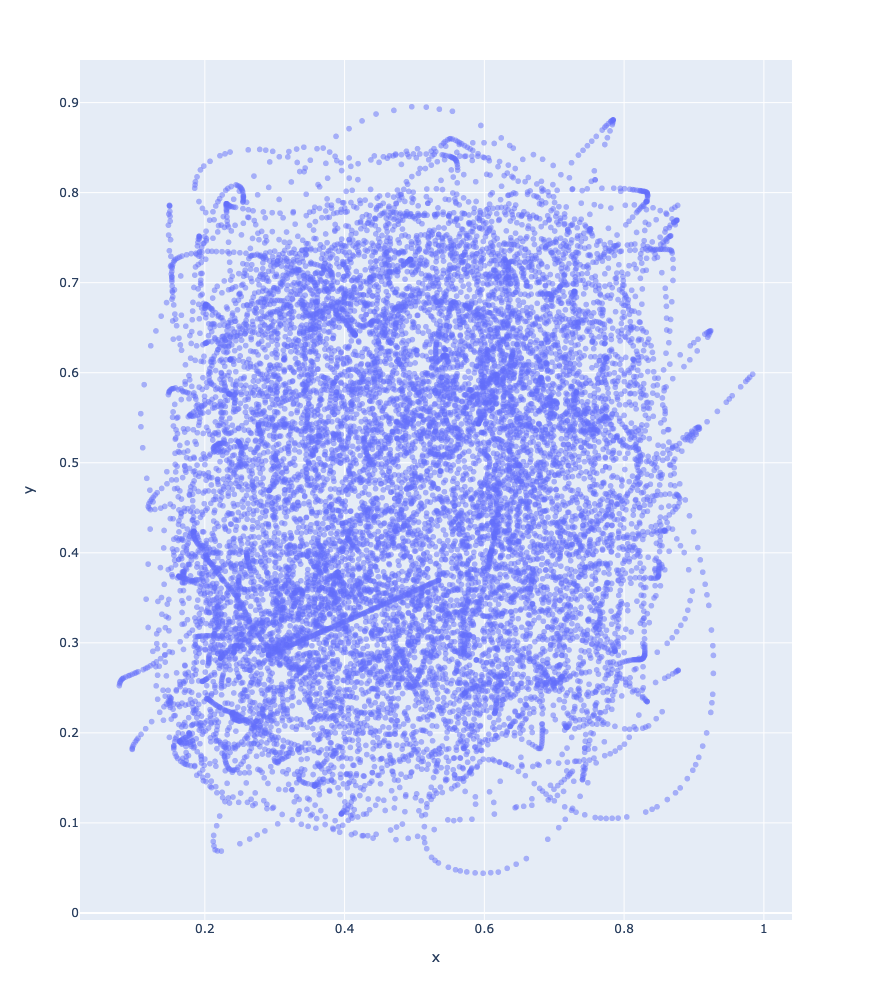

In [15]:
fig = px.scatter(x=data_df['x'], y=data_df['y'], opacity=0.5)
fig.layout.update(showlegend=False,
                  autosize=False,
                  width=1000,
                  height=1000,)
fig

## figure segments

In [16]:
import plotly.graph_objects as go

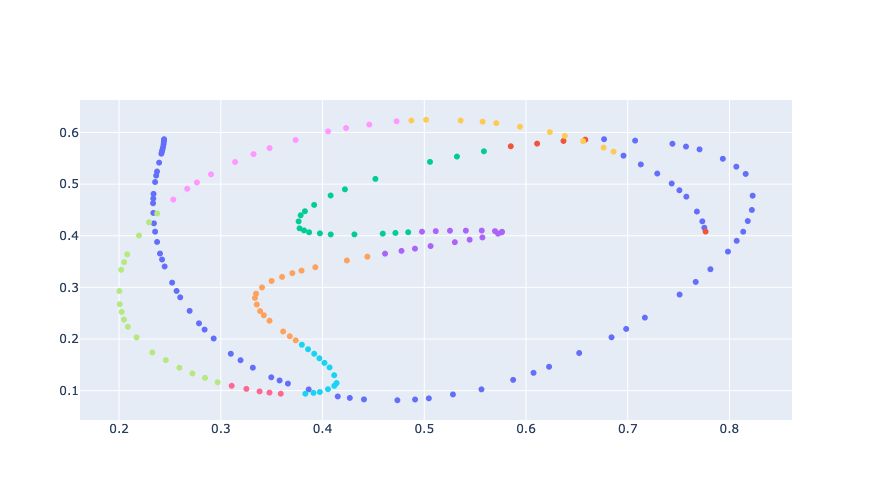

In [17]:
# select stroke
stroke_i = select(data_df, stroke_id=17).copy()

if stroke_i.shape[0] > 0:
    # stroke_i_feat = stroke_i.join(df.set_index('key'), on='key').dropna()
    # if stroke_i_feat.shape[0] > 0:
    # p_scaled = mms.transform(stroke_i['p'].values.reshape(-1,1)).reshape(-1)
    colors = ["rgba"+str(tab10[int(i)%10]+(1,)) for i in stroke_i['segment_id']]
    stroke_i['color'] = colors
    fig = px.scatter(data_frame=stroke_i, x='x', y='y', color='color', custom_data=['segment_id'])

fig = go.Figure(data=fig.data)
fig.update_traces(
    hovertemplate="ID:%{customdata} <br>t:%{x:.2f} <br>s:%{y:.2f}<extra></extra>"
    )
fig.layout.update(
    showlegend=False,
    autosize=False,
    width=500,
    height=500,
)
fig

## clusterisation

In [19]:
import clusterisation

In [20]:
clusterisation = reload(clusterisation)

In [21]:
segments = [grp[['s', 'da', 'p']].values for i, grp in data_df.groupby('segment_id')]

In [22]:
import contextlib
import joblib
from tqdm import tqdm

In [23]:
# https://stackoverflow.com/questions/24983493/tracking-progress-of-joblib-parallel-execution
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [24]:
from joblib import Parallel, delayed

total = len(np.triu_indices(len(segments), k=1, m=len(segments))[0])

with tqdm_joblib(tqdm(desc="My calculation", total=total)) as progress_bar:
    sm_seg = clusterisation.compute_similarity_matrix(segments)

My calculation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 274911/274911 [00:17<00:00, 16053.87it/s]


In [20]:
%%time
sm_seg = clusterisation.compute_similarity_matrix(segments)

CPU times: user 4.46 s, sys: 39.7 ms, total: 4.5 s
Wall time: 4.66 s


In [25]:
import warnings

In [26]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    emb_seg = clusterisation.tsne_embed(sm_seg, perplexity=30) 

===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.9606, 50 iterations in 0.5711 sec
Iteration  100, KL divergence 2.9262, 50 iterations in 0.5848 sec
Iteration  150, KL divergence 2.9312, 50 iterations in 0.6255 sec
Iteration  200, KL divergence 2.9210, 50 iterations in 0.5929 sec
Iteration  250, KL divergence 2.9267, 50 iterations in 0.5861 sec
   --> Time elapsed: 2.96 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 1.0276, 50 iterations in 0.5952 sec
Iteration  100, KL divergence 0.9175, 50 iterations in 0.6349 sec
Iteration  150, KL divergence 0.8916, 50 iterations in 0.5988 sec
Iteration  200, KL divergence 0.8854, 50 iterations in 0.6175 sec
Iteration  250, KL divergence 0.8839, 50 iterations in 0.7620 sec
Iteration  300, KL divergence 0.8818, 50 iterations in 0.7622 sec
Iteration  350, KL divergence 0.8811, 50 iterations in 0.7376 sec
Iteration

In [27]:
emb_seg

TSNEEmbedding([[  8.81644972, -14.06732044],
               [ -2.40543531, -12.28108471],
               [-23.91303322, -13.78525672],
               ...,
               [ -4.12340984, -20.23987862],
               [  7.46042022,  25.23055176],
               [  7.45633362,  26.11926745]])

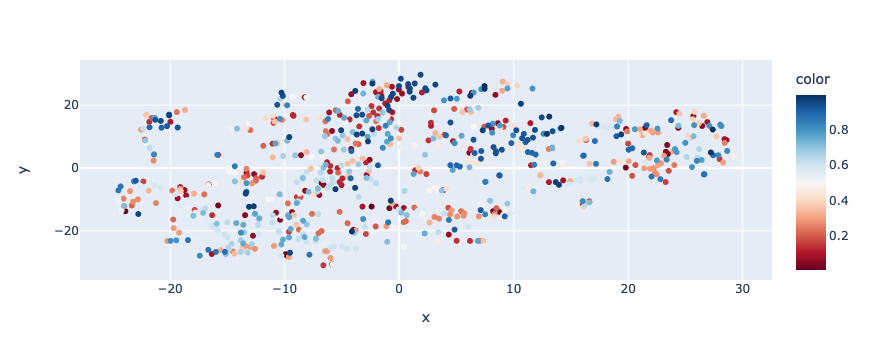

In [28]:
fig = px.scatter(data_frame=pd.DataFrame(emb_seg, columns=['x', 'y']), 
                 x='x', y='y', color=data_df.groupby('segment_id')['t0_'].mean(),
                 color_continuous_scale='rdbu',
                 hover_data={'segment_id': list(set(data_df['segment_id'].values)), 'x': False, 'y': False,},
                )
fig.layout.update(
showlegend=False,
)
fig

## facet plot per segments

In [30]:
segment_ids = list(set(data_df['segment_id']))

In [31]:
N = 16
segments_N = np.random.choice(segment_ids, size=N, replace=False)

In [32]:
segments_N_data = select(data_df, segment_id=list(segments_N)).copy()

In [33]:
segments_N_data['ts_'] = 0

In [34]:
def add_ts_(grp):
    grp['ts_'] = np.arange(grp.shape[0])
    return grp
segments_N_data = segments_N_data.groupby('segment_id').apply(add_ts_)

In [35]:
segments_N_data.groupby('segment_id').size()

segment_id
142    11
168    25
190    62
217    15
234    19
272    19
324     9
333    10
355    10
380    11
493    12
560    18
584    44
639    36
753    27
756    21
dtype: int64

In [36]:
segments_N_data

key      t0    ts  stroke_id  segment_id         x         y  \
625    520825_5170  520825  5170         13         142  0.707759  0.623088   
626    520825_5180  520825  5180         13         142  0.711931  0.617218   
627    520851_5190  520851  5190         13         142  0.714824  0.611807   
628    520851_5200  520851  5200         13         142  0.717717  0.606396   
629    520867_5210  520867  5210         13         142  0.721187  0.597862   
...            ...     ...   ...        ...         ...       ...       ...   
13344  698069_2440  698069  2440         68         756  0.627098  0.635175   
13345  698069_2450  698069  2450         68         756  0.646494  0.616320   
13346  698090_2460  698090  2460         68         756  0.656300  0.608038   
13347  698090_2470  698090  2470         68         756  0.663708  0.602400   
13348  698104_2480  698104  2480         68         756  0.679388  0.592438   

              p        x_        y_  ...        x0        y0        p0  \
625    0.133536  0.488324 -0.062855  ...  0.441098 -0.029728  0.195101   
626    0.124545  0.492496 -0.068726  ...  0.450967 -0.033375  0.170838   
627    0.118361  0.495389 -0.074137  ...  0.460064 -0.037610  0.150970   
628    0.112177  0.498281 -0.079548  ...  0.468228 -0.042540  0.135051   
629    0.105710  0.501752 -0.088081  ...  0.475438 -0.048192  0.122064   
...         ...       ...       ...  ...       ...       ...       ...   
13344  0.207078  0.300429  0.396955  ...  0.267751  0.434163  0.229538   
13345  0.215763  0.319825  0.378100  ...  0.275535  0.429041  0.222856   
13346  0.215574  0.329631  0.369818  ...  0.281210  0.422874  0.216531   
13347  0.213166  0.337039  0.364179  ...  0.285705  0.416107  0.211189   
13348  0.223949  0.352719  0.354218  ...  0.290201  0.408907  0.207169   

             x1        y1        p1         s        da       t0_  ts_  
625    0.010326 -0.002551 -0.030241  1.063649 -0.083937  0.052011    0  
626    0.010158 -0.003028 -0.028352  1.059944 -0.066510  0.052011    1  
627    0.009816 -0.003508 -0.025497  1.042393 -0.055504  0.052135    2  
628    0.009265 -0.004043 -0.022057  1.010826 -0.054694  0.052135    3  
629    0.008534 -0.004639 -0.018544  0.971284 -0.063310  0.052211    4  
...         ...       ...       ...       ...       ...       ...  ...  
13344  0.013510 -0.000319 -0.001879  1.351390 -0.091339  0.896602   16  
13345  0.011496 -0.002197 -0.004123  1.170390 -0.117266  0.896602   17  
13346  0.009340 -0.003856 -0.005382  1.010450 -0.148719  0.896702   18  
13347  0.007419 -0.005184 -0.005731  0.905058 -0.179784  0.896702   19  
13348  0.006091 -0.006177 -0.005339  0.867530 -0.195849  0.896768   20  

[349 rows x 21 columns]

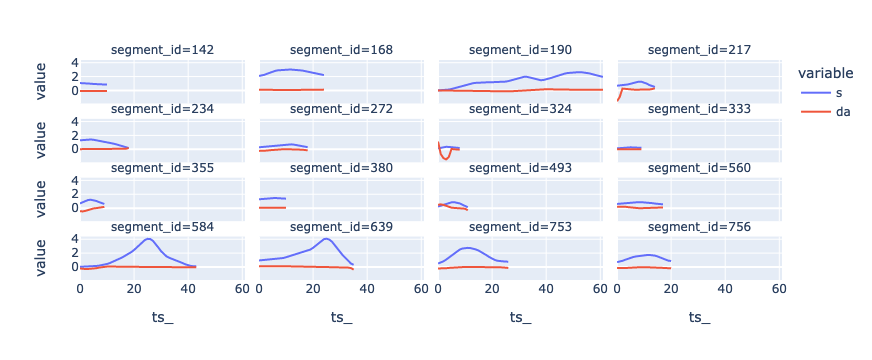

In [39]:
px.line(data_frame=segments_N_data, x='ts_', y=['s', 'da'], facet_col='segment_id', facet_col_wrap=4)